In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
%cd /content/drive/MyDrive/3D_Vision_Class/term_project/part2/ 
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

/content/drive/MyDrive/3D_Vision_Class/term_project/part2


Corner Extraction

In [2]:
def extract_points(euroc=False):
  if euroc:
    # Detect the checkerboard points
    points_2d = []
    points_3d = []

    # Create calib object 3D points
    w = 7
    h = 6
    M = np.zeros((h*w, 3), np.float32)
    M[:, :2] = np.mgrid[0:h, 0:w].T.reshape(-1, 2) # (n,3)
    M *= 0.06
    sayi = 0
    selected_imgs = {}
    main_path = "/content/drive/MyDrive/3D_Vision_Class/term_project/part2/euroc_imgs"
    files = os.listdir(main_path)
    img_names = []
    for f in files:
      img = cv2.imread(os.path.join(main_path, f))
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      ret, pnts = cv2.findChessboardCorners(img_gray, (h,w), cv2.CALIB_CB_ADAPTIVE_THRESH)

      if ret == True:
        # Refine pixel coordinates
        corners2 = cv2.cornerSubPix(
                  img_gray, pnts, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS +
                  cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

        points_2d.append(corners2.squeeze(1)) #(n, 2)

        points_3d.append(M)

        # Draw and display the corners
        image = cv2.drawChessboardCorners(img_gray,
                                          (h,w),
                                        corners2, ret)
        selected_imgs[f] = img 
        cv2_imshow(image)
        img_names.append(f)
    #first_image = img_names[0]
  else:
    save_path = "/content/drive/MyDrive/3D_Vision_Class/term_project/part2/"
    points_3d = np.load(os.path.join(save_path, "points_3d_new.npy"))
    points_2d = np.load(os.path.join(save_path, "points_2d_new.npy")) 
    

  return points_3d, points_2d




Camera Calibration

In [8]:
def calc_init_parameters(points_3d, points_2d):
  homographies = []
  Vs = []
  for idx, M in enumerate(points_3d):
    # for each image estimate H
    L = []
    for i in range(M.shape[0]):
      Mi = M[i, :] # 3D point
      xi = points_2d[idx][i, :] # 2D image point
      row1 = np.array([Mi[0], Mi[1], 1, 0, 0, 0, -xi[0]*Mi[0], -xi[0]*Mi[1], -xi[0]])
      L.append(row1)
      row2 = np.array([0, 0, 0, Mi[0], Mi[1], 1, -xi[1]*Mi[0], -xi[1]*Mi[1], -xi[1]])
      L.append(row2)
      #print("Mi: ", Mi)
    L = np.array(L) #(2*n, 9)
    U, D, V = np.linalg.svd(L)
    H = V[-1, :].reshape((3, 3))
    H = H / H[2,2]  
    homographies.append(H)
    #print("H: ", H)
    #print("L: ", L)
    h1 = H[:, 0]
    h2 = H[:, 1]
    v_12 = np.array([h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1], h1[2]*h2[0]+h1[0]*h2[2], h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]])
    Vs.append(v_12.T)
    v_11 = np.array([h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1], h1[2]*h1[0]+h1[0]*h1[2], h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]])
    v_22 = np.array([h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1], h2[2]*h2[0]+h2[0]*h2[2], h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]]) 
    Vs.append((v_11-v_22).T)

  Vs = np.array(Vs)
  U, D, V = np.linalg.svd(Vs)
  b = V[-1, :]
  v0 = (b[1]*b[3] - b[0]*b[4]) / (b[0]*b[2] - b[1]**2)
  lamb = b[5] - (b[3]**2 + v0*(b[1]*b[3]-b[0]*b[4]))/b[0]
  alpha = np.sqrt(lamb/b[0])
  beta = np.sqrt((lamb*b[0]) / (b[0]*b[2] - b[1]**2))
  gamma = -b[1]*beta*(alpha**2) / lamb
  u0 = gamma*v0/beta - b[3]*(alpha**2) / lamb
  # Initial intrinsic matrix
  A = np.array([[alpha, gamma, u0], [0, beta, v0], [0,0,1]])

  # Calculate the extrinsic parameters for each image
  A_inv = np.linalg.pinv(A)
  extrinsics = {}
  extr = []
  for idx, H in enumerate(homographies):
    h1 = H[:,0]
    h2 = H[:,1]
    h3 = H[:,2]
    lamb = 1/np.linalg.norm(A_inv.dot(h1))
    r1 = lamb*np.dot(A_inv, h1)
    r2 = lamb*np.dot(A_inv, h2)
    r3 = np.cross(r1, r2)
    t = np.expand_dims(lamb*np.dot(A_inv, h3), axis=1) # (3,1)
    T = np.concatenate([np.expand_dims(r1,1), np.expand_dims(r2,1), np.expand_dims(r3,1), t], axis=1)
    extr.append(T)
    extrinsics["img"+str(idx+1)] = [np.expand_dims(r1, 1), np.expand_dims(r2, 1), np.expand_dims(r3, 1), t, lamb]
  
  # Distortion modelling
  D = []
  d = []
  for idx, M in enumerate(points_3d): # M(n,3), u_pr(n,3) for each img
    u_pr = points_2d[idx]
    T = extr[idx]
    N = u_pr.shape[0]
    M_aug = np.column_stack([M, np.ones((N, 1))])
    M_aug = np.dot(T, M_aug.T) # (3, N)
    for i in range(M.shape[0]):
      x = M_aug[:, i]
      x = x[:] / x[2]
      x_pr = np.dot(A, x) 
      r2 = x[0]**2 + x[1]**2
      r4 = r2**2
      tmp1 = x_pr[0] - u0
      tmp2 = x_pr[1] - v0
      tmp3 = np.array([[tmp1*r2, tmp1*r4], [tmp2*r2, tmp2*r4]])
      D.append(tmp3)
      tmp4 = np.array([[u_pr[i, 0]-x_pr[0]], [u_pr[i, 1] - x_pr[1]]])
      d.append(tmp4)
  D = np.array(D).reshape(-1, 2)  # (2mn, 2)
  d = np.array(d).reshape(-1, 1) # (2mn, 1)

  k = np.dot(np.linalg.pinv(D.T.dot(D)), D.T.dot(d)) #(2, 1)

  return A, extrinsics, k


# Reprojection Function
def fun(params, points_3d, points_2d):
  N = len(points_2d)
  params0 = params[7:]
  extr = []
  for t in range(N):
    T = np.eye(4)
    tvec = params0[6*t:6*t+6]
    R = cv2.Rodrigues(tvec[:3])[0]
    T[:3, :3] = R
    T[:3, 3] = tvec[3:]
    extr.append(T)

  A = np.array([[params[0], params[1], params[2]], [0, params[3], params[4]], [0,0,1]]) 
  

  # Augment the points
  M_homo = np.column_stack((points_3d[0], np.ones((points_3d[0].shape[0],1)))) #(N,4)
  k2 = params[6]
  k1 = params[5]
  v0 = params[4]
  u0 = params[2]
  residuals = []
  for idx, img in enumerate(points_2d):
    for i in range(img.shape[0]):
      m = img[i, :] # (2,)
      M = M_homo[i, :] # (4,)
      T= extr[idx]
      
      X = np.dot(T, M) # (4,)
      x = X[:3] / X[2] # (3,)
      #uv = np.array([M[0], M[1], 1])
      uv = np.dot(A, x)[:2] #/ uv[2]
      r = x[0]**2 + x[1]**2
      r_sq = r**2
      u_hat = uv[0] + (uv[0]-u0)*(k1*r + k2*r_sq)
      v_hat = uv[1] + (uv[1]-v0)*(k1*r + k2*r_sq)
      m_hat = np.array([u_hat, v_hat])
      res = (m_hat-m)
      #residuals.append(res)
      #res = np.linalg.norm(res, ord=2)
      residuals.append(res)
  
  residuals = np.array(residuals).ravel()
  #print(residuals.shape)
  return residuals


def bundle_adjustment(points_3d, points_2d, extrinsics, intrinsics, k):
  alpha = intrinsics[0]
  gamma = intrinsics[1]
  u0 = intrinsics[2]
  beta = intrinsics[3]
  v0 = intrinsics[4]

  # Prepare initial parameters
  cam_extrinsics = []
  for i in range(len(points_3d)):
    tmp = np.eye(4)
    r1 = extrinsics["img"+str(i+1)][0].squeeze()
    r2 = extrinsics["img"+str(i+1)][1].squeeze()
    r3 = extrinsics["img"+str(i+1)][2].squeeze()
    t = extrinsics["img"+str(i+1)][3].squeeze()
    tmp[:3, 0] = r1
    tmp[:3, 1] = r2
    tmp[:3, 2] = r3
    tmp[:3, 3] = t
    rvec = cv2.Rodrigues(tmp[:3, :3])[0] #SE2se(tmp)
    #print(rvec.shape, t.shape)
    tempr = np.concatenate([rvec.squeeze(), t]).T
    #print(tempr.shape)
    cam_extrinsics.append(tempr)
    
  cam_extrinsics = np.array(cam_extrinsics)
  cam_intrinsics = np.array([alpha, gamma, u0, beta, v0])
  dist_params = np.array([k[0], k[1]])
  x0 = np.hstack((cam_intrinsics.ravel(), dist_params.ravel(), cam_extrinsics.ravel()))

  # Conduct BA
  res = least_squares(fun, x0, verbose=2, method='lm', ftol=1e-4,
                      args=(points_3d, points_2d))

  opt_intr = res["x"][:7]
  A_opt = np.array([[opt_intr[0], opt_intr[1], opt_intr[2]], [0, opt_intr[3], opt_intr[4]], [0,0,1]], np.float32)
  k_opt = np.array([opt_intr[-2], opt_intr[-1]])

  opt_extrinsics = []
  for i in range(len(points_2d)):
    T = np.eye(4)
    trans = res["x"][7:][6*i:6*i+6]
    R = cv2.Rodrigues(trans[:3])[0]
    T[:3, :3] = R
    T[:3, 3] = trans[3:]
    opt_extrinsics.append(T)
  
  return A_opt, k_opt, opt_extrinsics, res



def calibration(points_3d, points_2d):
  # Calculate initial parameter values
  A_init, extrinsics_init, k_init = calc_init_parameters(points_3d, points_2d)
  
  # Refine the parameters with BA
  intrinsic_init = [A_init[0,0], A_init[0,1], A_init[0,2], A_init[1,1], A_init[1,2]]
  A_opt, k_opt, extrinsics_opt, res = bundle_adjustment(points_3d, points_2d, extrinsics_init, intrinsic_init, k_init)
  
  return A_opt, k_opt, extrinsics_opt, res


Image Undistortion and 3D Object Projection

In [9]:
def undistortion(img_path, A_opt, k_opt, save_path=None):
  img = cv2.imread(img_path)
  un_img = cv2.undistort(img, A_opt, np.concatenate([k_opt, [0,0]]), None)
  
  if save_path != None:
    cv2.imwrite(os.path.join(save_path, "undistorted.png"), un_img)
  
  return un_img

class OBJ:
    def __init__(self, filename, swapyz=False):
        """Loads a Wavefront OBJ file. """
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        material = None
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(map(float, values[1:3]))
            #elif values[0] in ('usemtl', 'usemat'):
                #material = values[1]
            #elif values[0] == 'mtllib':
                #self.mtl = MTL(values[1])
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                #self.faces.append((face, norms, texcoords, material))
                self.faces.append((face, norms, texcoords))

def project_3d_obj(obj_path, img_idx, A_opt, k_opt, opt_extrinsics, un_img, save_path):
  scale_mtx = 0.08 * np.eye(3)
  obj = OBJ(obj_path, swapyz=True)
  vertices = np.array(obj.vertices) # (N, 3)
  vertices = np.dot(vertices, scale_mtx) # Scale the 3D object
  vert_aug = np.column_stack([vertices, np.ones((vertices.shape[0], 1))]) # (N,4)
  T = opt_extrinsics[img_idx]
  rvec = cv2.Rodrigues(T[:3, :3])[0]
  tvec = T[:3, 3]
  P = np.dot(A_opt, T[:3, :])  # (3,4)
  #img_points = np.dot(P, vert_aug.T) # (3,N)
  #img_points[:2, :] /= img_points[2, :]
  img_points, _ = cv2.projectPoints(vertices, rvec, tvec, A_opt, np.concatenate([k_opt, [0,0]]))
  for i in range(img_points.shape[0]):
    x = int(img_points[i, 0, 0])
    y = int(img_points[i, 0, 1])
    un_img = cv2.circle(un_img, (x,y), 0, (0,255,0), -1)

  cv2.imwrite(os.path.join(save_path, "VR_Img.png"), un_img)
  cv2_imshow(un_img) 


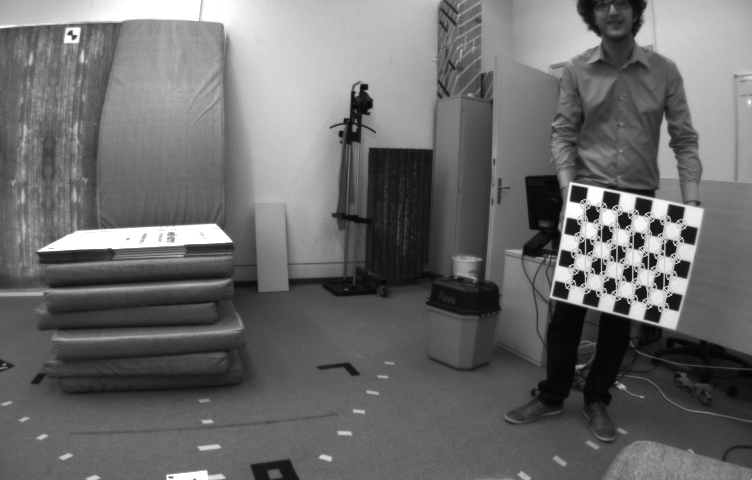

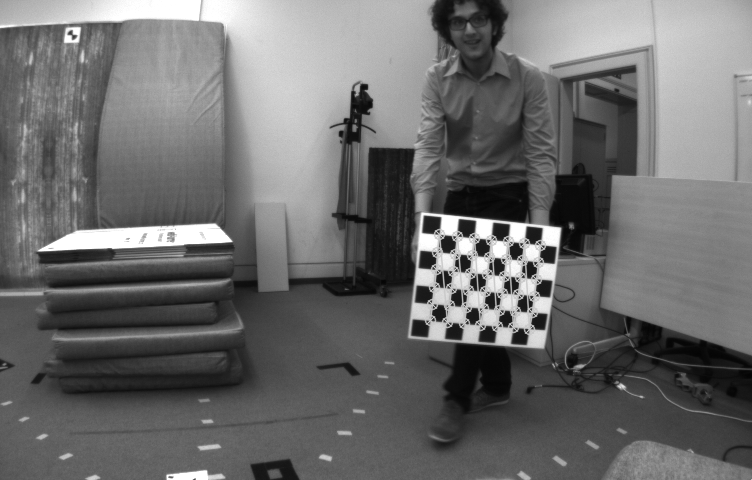

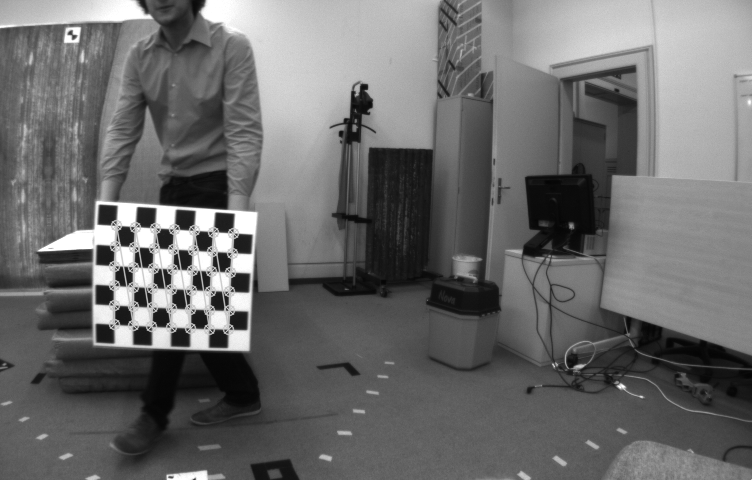

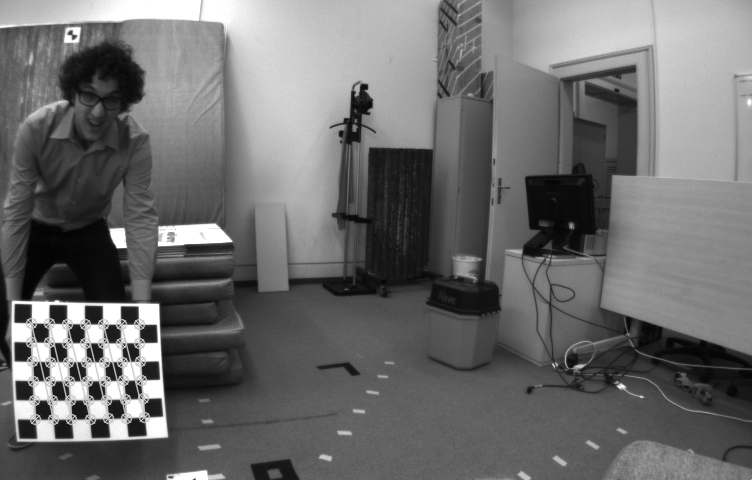

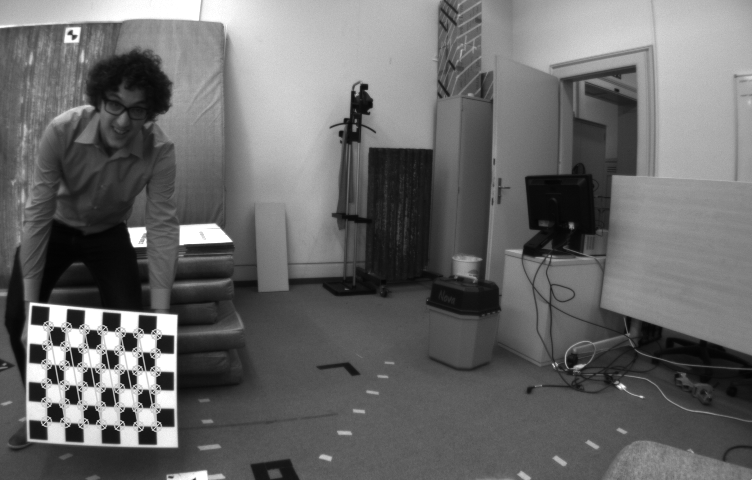

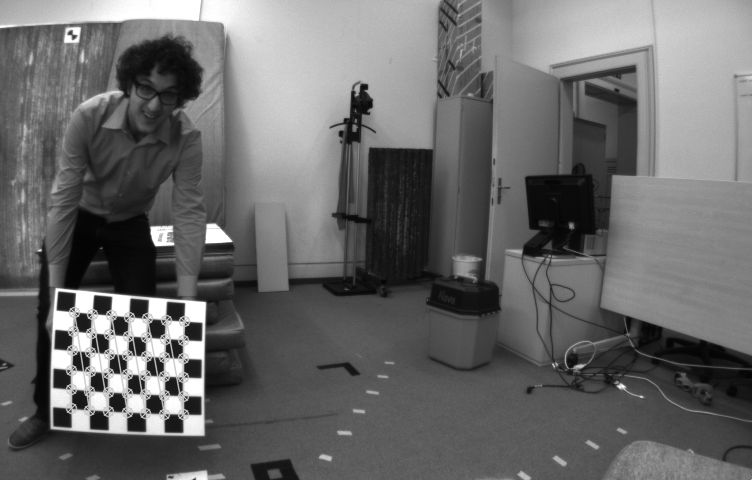

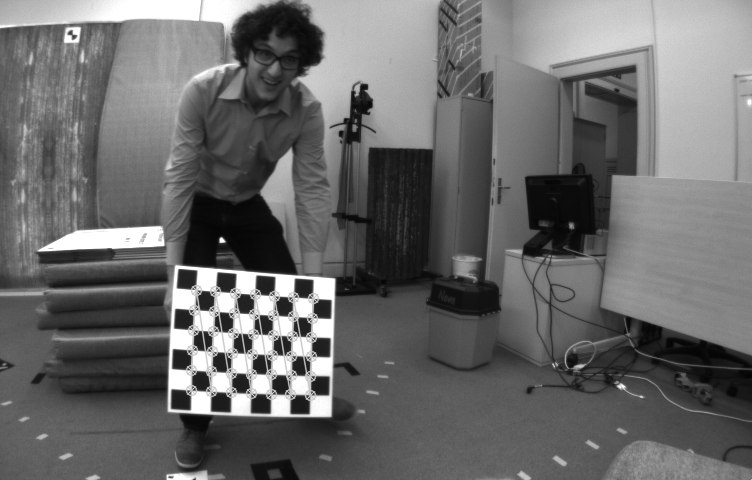

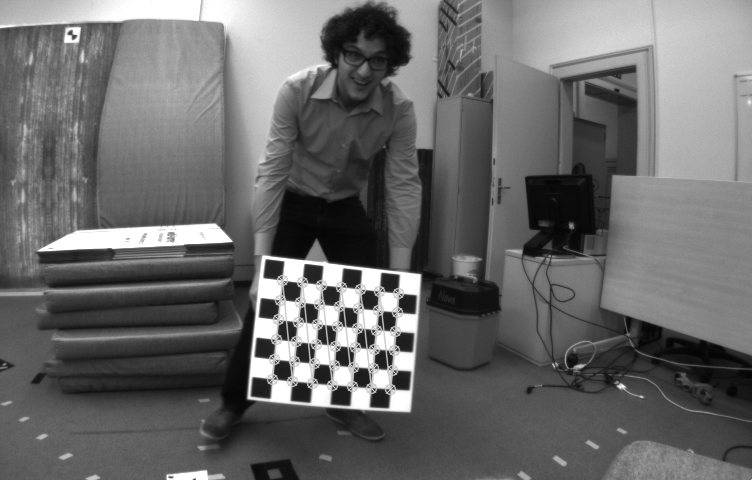

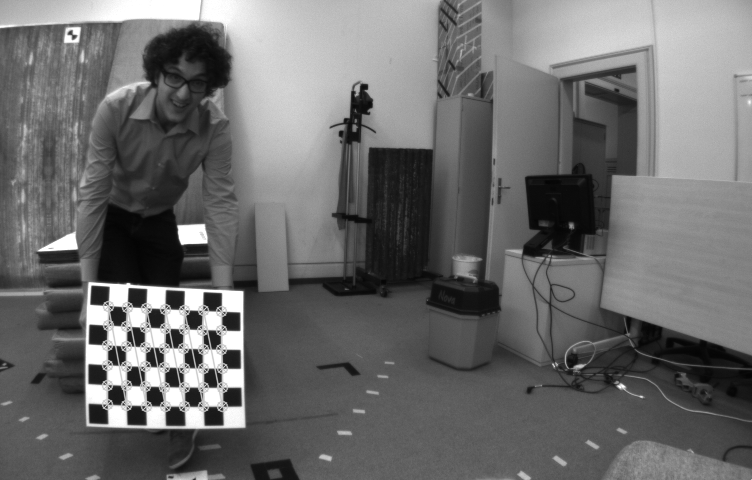

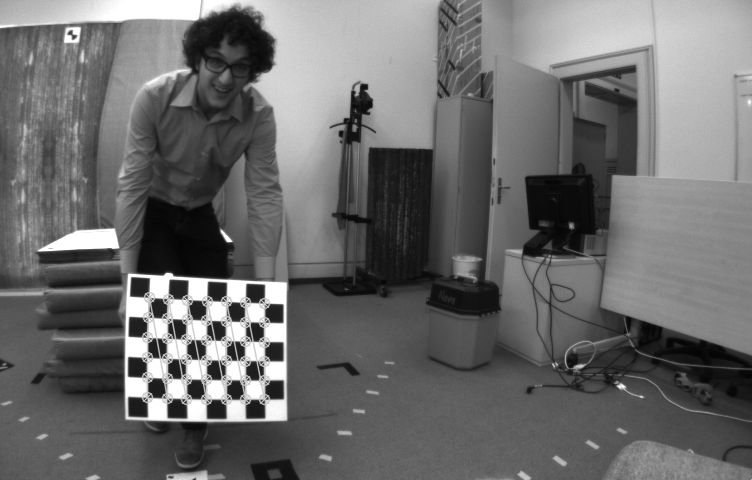

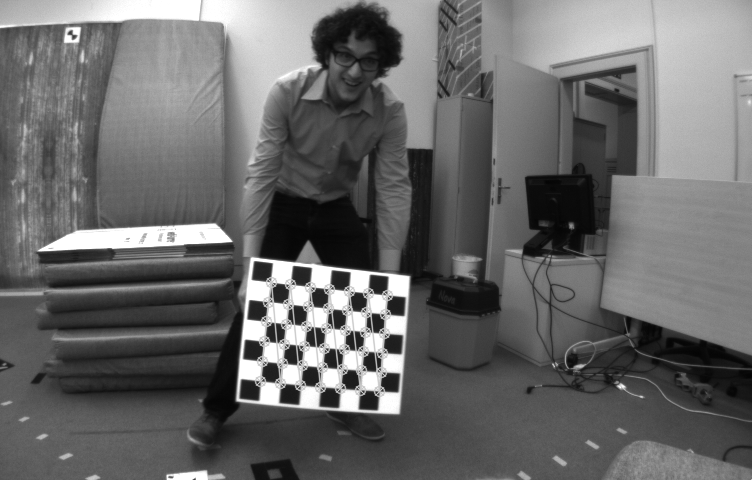

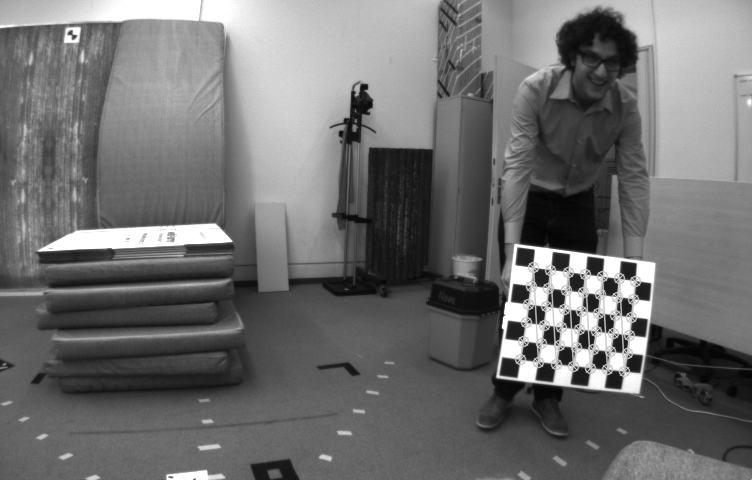

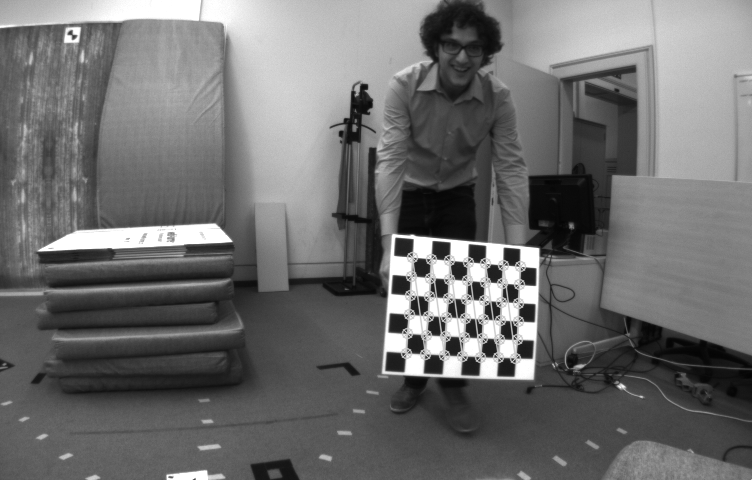

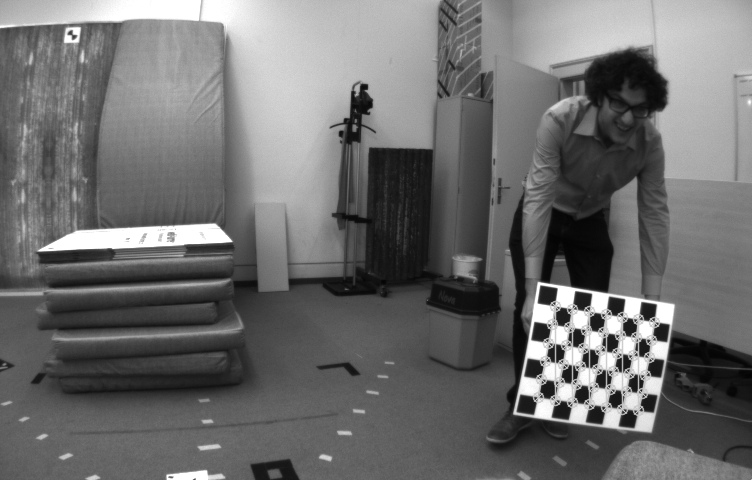

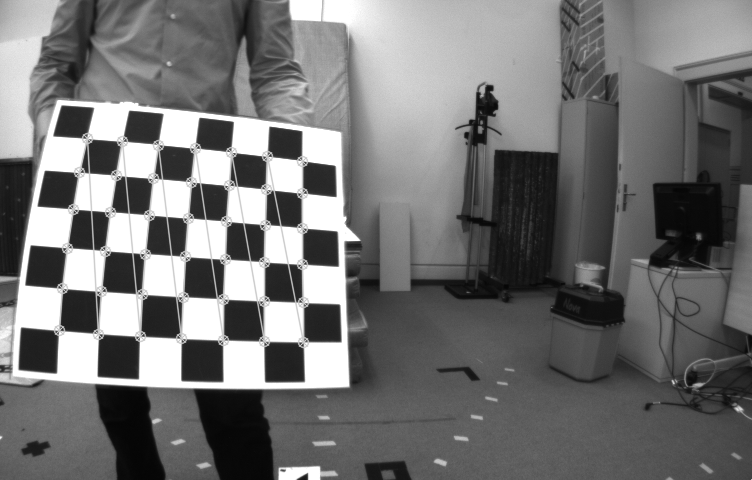

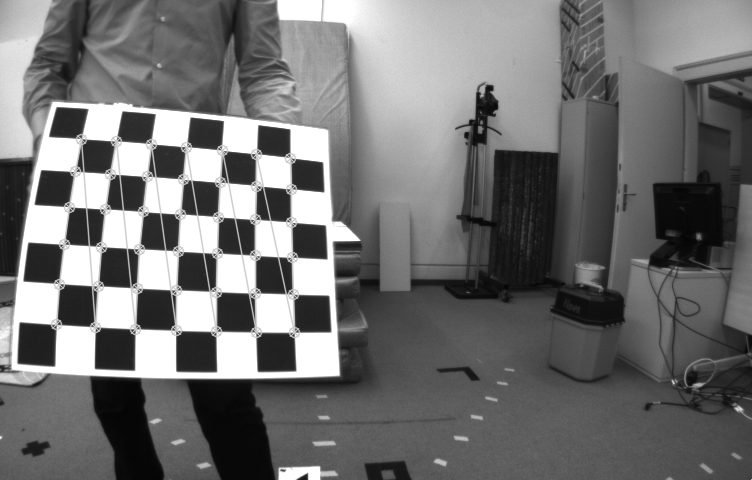

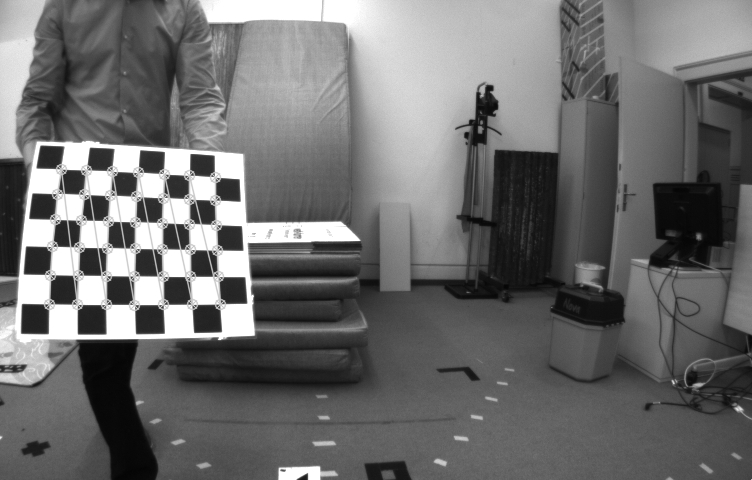

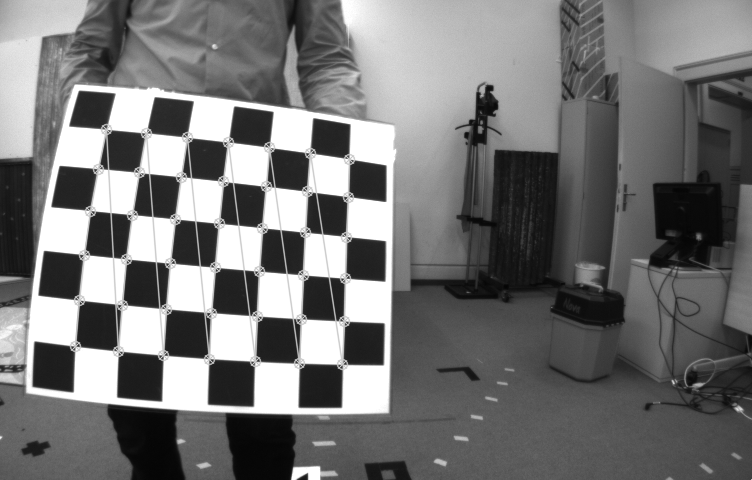

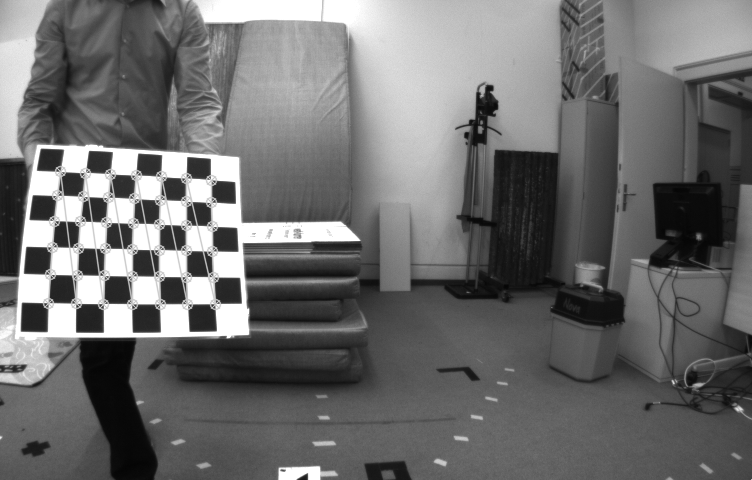

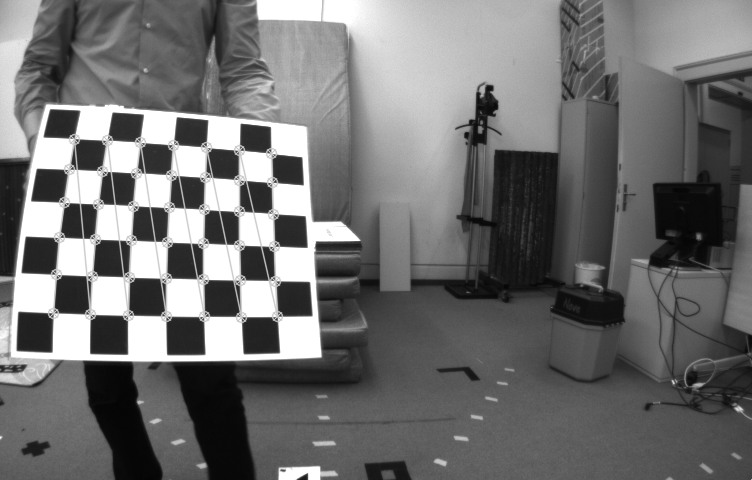

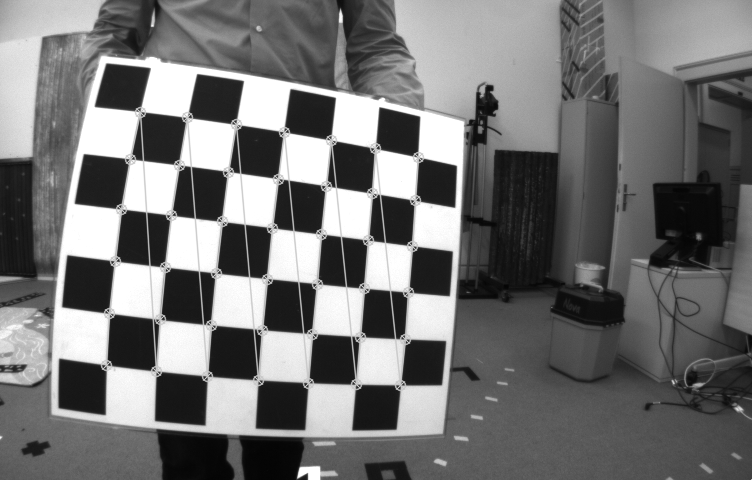

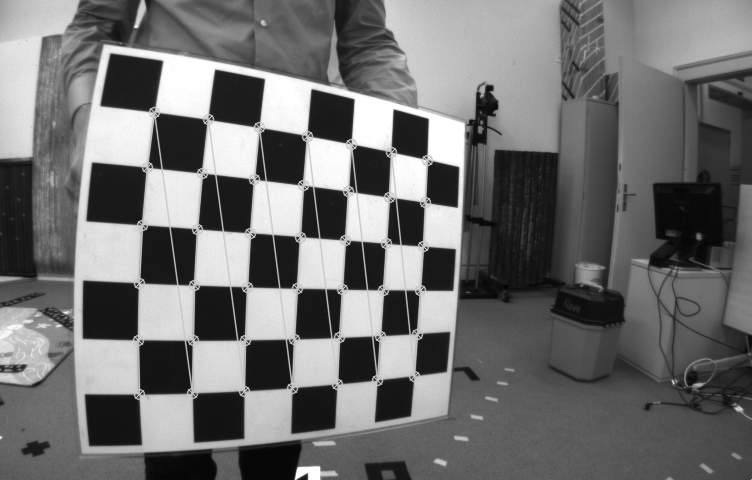

`ftol` termination condition is satisfied.
Function evaluations 2384, initial cost 1.3138e+04, final cost 6.2862e+00, first-order optimality 1.82e-02.
Max res:  0.8021088522180406


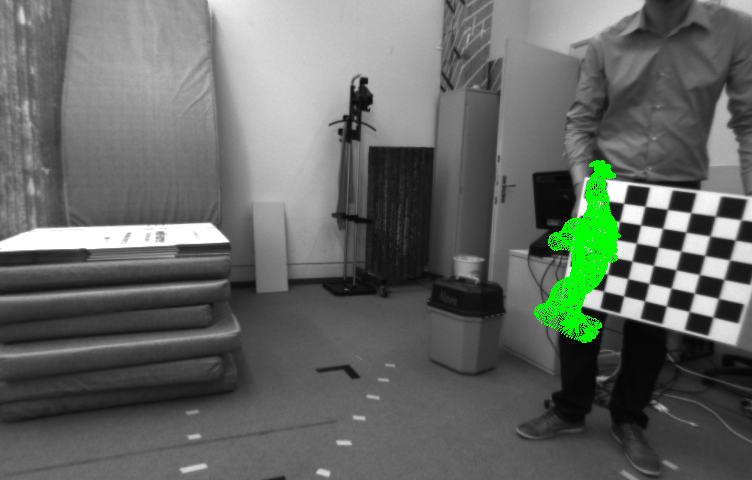

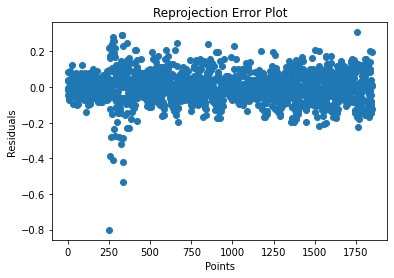

In [10]:

def plot(points_3d, points_2d, res):
  residuals = fun(res["x"], points_3d, points_2d)
  plt.scatter(range(0, residuals.shape[0]),residuals)
  plt.xlabel("Points")
  plt.ylabel("Residuals")
  plt.title("Reprojection Error Plot")
  #plt.savefig("HW_Calibration_Reprojection_Plot.png")
  print("Max res: ", np.abs(residuals).max())
  


def main():
  # Corner Extraction
  # If you want to calibrate Euroc MAV Dataset, make euroc to be equal to True
  points_3d, points_2d = extract_points(euroc=True)

  # Camera Calibration with BA
  A_opt, k_opt, extrinsics_opt, res =  calibration(points_3d, points_2d)

  # Plot residual error scatter plot, world-camera centric poses
  plot(points_3d, points_2d, res)
  
  # Undistort an image
  img_path =  "/content/drive/MyDrive/3D_Vision_Class/term_project/part2/euroc_imgs/1403709033387836928.png"
  save_path = "/content/drive/MyDrive/3D_Vision_Class/term_project/part2"
  un_img = undistortion(img_path, A_opt, k_opt, save_path)

  # Project 3D object onto the calibration object in the undistorted image
  obj_path = "/content/drive/MyDrive/3D_Vision_Class/term_project/part2/mesh.obj"
  img_idx = 0
  project_3d_obj(obj_path, img_idx, A_opt, k_opt, extrinsics_opt, un_img, save_path)


main()